# Validations

In [1]:
using Plots
using Plots.PlotMeasures
using ModelingToolkit
using DifferentialEquations
using LaTeXStrings
using RetroSignalModel
import RetroSignalModel as rs


In [2]:
@named sys = RtgMTK(rs.ONE_SIGNAL)
u0 = rs.resting_u0(sys)

ks = load_parameters("solution_rtgM4.csv")[1]
prob = SteadyStateProblem(sys, u0, ks)
# Warm up
sol = solve(prob, DynamicSS(Rodas5()));


In [3]:
# parameter map
psmap = Dict(k => i for (i, k) in enumerate(parameters(sys)))


Dict{SymbolicUtils.BasicSymbolic{Real}, Int64} with 30 entries:
  k2I    => 1
  kn2M   => 6
  k2M    => 7
  k13ID  => 11
  kn13_c => 16
  k1out  => 20
  k3outI => 25
  ΣRtg3  => 28
  knBM   => 8
  kn13_n => 18
  ΣRtg2  => 27
  mul_S  => 5
  ΣMks   => 29
  ΣRtg1  => 26
  k3inI  => 24
  n_S    => 2
  ksV    => 3
  k13_c  => 17
  k3I_n  => 15
  k3I_c  => 14
  k1in   => 21
  k3inA  => 23
  k3outA => 22
  k13I   => 10
  kBM    => 9
  ⋮      => ⋮

## Bmh partial knockout

Initial protein concentrations: Get expression levels: uses data from [GSE102475](https://github.com/NTUMitoLab/RetroSignalModel.jl).

In [4]:
idxmulS = psmap[rs.mul_S]

r3nc_wt = map(0.0:0.02:1.0) do s
    p = copy(prob.p)
    p[idxmulS] = s
    sol = solve(remake(prob, p=p), DynamicSS(Rodas5()))
    rs.rtg3_nucleus(sol) / rs.rtg3_cytosol(sol)
end


51-element Vector{Float64}:
 0.5380120328140365
 0.5380120329197654
 0.5380177793401011
 0.5380382610448478
 0.5381792015370671
 0.5387825098736928
 0.5406877707309385
 0.5454584460321569
 0.555863531592004
 0.5765254942782465
 0.6147461008995452
 0.6805583806516806
 0.7856484221051576
 ⋮
 4.578586064944932
 4.581865304210822
 4.5845521533143705
 4.5867672373739845
 4.588599598412896
 4.590120543543677
 4.5913905088803455
 4.592453380282793
 4.593349570045431
 4.59410450570078
 4.594742660602246
 4.595284467339579

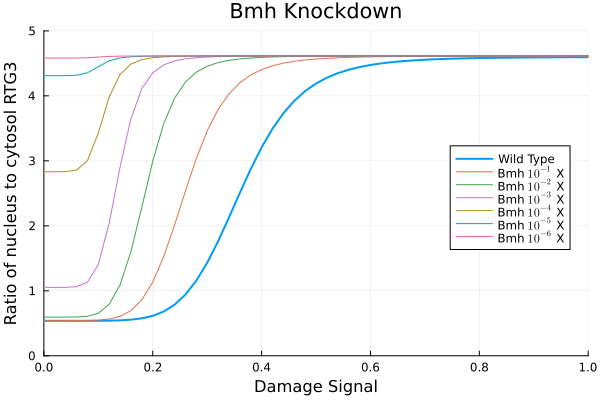

In [5]:
plot(0.0:0.02:1.0, r3nc_wt, label="Wild Type", lw=2)

idxBmh = psmap[rs.ΣBmh]

for i in 1:6
    r3nc_Δb = map(0.0:0.02:1.0) do s
        p = copy(prob.p)
        p[idxmulS] = s
        p[idxBmh] = prob.p[idxBmh] / 10^i
        sol = solve(remake(prob, p=p), DynamicSS(Rodas5()))
        rs.rtg3_nucleus(sol) / rs.rtg3_cytosol(sol)
    end

    plot!(0.0:0.02:1.0, r3nc_Δb, label = string("Bmh ", L"10^{-%$i}", " X"))
end

plot!(legend=:right, title="Bmh Knockdown", xlabel="Damage Signal", ylabel="Ratio of nucleus to cytosol RTG3", xlims=(0.0, 1.0), ylims=(0.0, 5.0))


## Mks partial knockdown

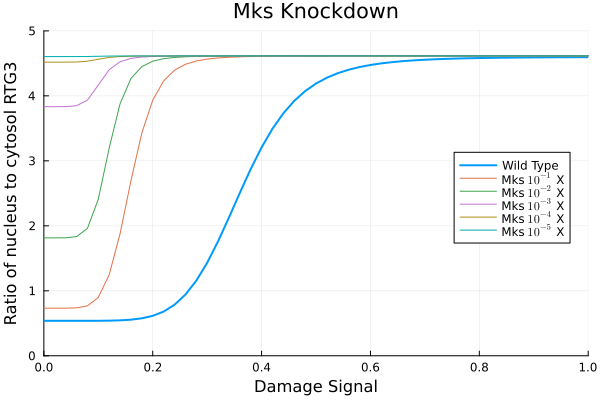

In [6]:
idxΣMks = psmap[rs.ΣMks]

plot(0.0:0.02:1.0, r3nc_wt, label="Wild Type", lw=2)

for i in 1:5
    r3nc_Δb = map(0.0:0.02:1.0) do s
        p = copy(prob.p)
        p[idxmulS] = s
        p[idxBmh] = prob.p[idxΣMks] / 10^i
        sol = solve(remake(prob, p=p), DynamicSS(Rodas5()))
        rs.rtg3_nucleus(sol) / rs.rtg3_cytosol(sol)
    end

    plot!(0.0:0.02:1.0, r3nc_Δb, label = string("Mks ", L"10^{-%$i}", " X"))
end

plot!(legend=:right, title="Mks Knockdown", xlabel="Damage Signal", ylabel="Ratio of nucleus to cytosol RTG3", xlims=(0.0, 1.0), ylims=(0.0, 5.0))


## Rapamycin and glutamate

`kn2M` was decreased ten times to simulated enhanced binding of Mks and Rtg2 upon Rapamycin / glutamate addition.

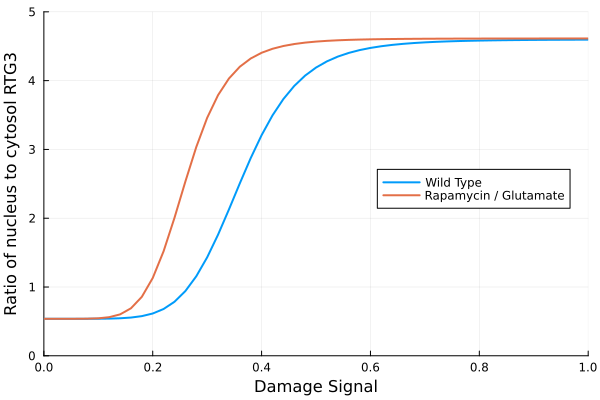

In [7]:
idxkn2M = psmap[rs.kn2M]
r3nc_ra = map(0.0:0.02:1.0) do s
    p = copy(prob.p)
    p[idxmulS] = s
    p[idxkn2M] /= 10
    sol = solve(remake(prob, p=p), DynamicSS(Rodas5()))
    rs.rtg3_nucleus(sol) / rs.rtg3_cytosol(sol)
end

pl1 = plot(0.0:0.02:1.0, [r3nc_wt r3nc_ra], label=["Wild Type" "Rapamycin / Glutamate"], lw=2, legend=:right,
    xlims=(0.0, 1.0), ylims=(0.0, 5.0),  xlabel="Damage Signal", ylabel="Ratio of nucleus to cytosol RTG3")


### Interactions with protein knockout

In [8]:
idxmulS = psmap[rs.mul_S]
idxBmh = psmap[rs.ΣBmh]
idxΣMks = psmap[rs.ΣMks]
idxkn2M = psmap[rs.kn2M]
idxΣRtg1 = psmap[rs.ΣRtg1]
idxΣRtg2 = psmap[rs.ΣRtg2]
idxΣRtg3 = psmap[rs.ΣRtg3]
idxkn2M = psmap[rs.kn2M]

function remake_rapa(prob)
    p = copy(prob.p)
    p[idxkn2M] /= 10
    remake(prob; p = p)
end

function remake_ΔBmh(prob)
    p = copy(prob.p)
    p[idxBmh] *= 1e-4
    remake(prob; p = p)
end

function remake_ΔMks(prob)
    p = copy(prob.p)
    p[idxΣMks] *= 1e-4
    remake(prob; p = p)
end

function remake_ΔRtg1(prob)
    p = copy(prob.p)
    p[idxΣRtg1] *= 1e-4
    remake(prob; p = p)
end

function remake_ΔRtg2(prob)
    p = copy(prob.p)
    p[idxΣRtg2] *= 1e-4
    remake(prob; p = p)
end

function remake_ΔRtg3(prob)
    p = copy(prob.p)
    p[idxΣRtg3] *= 1e-4
    remake(prob; p = p)
end

function get_r3nc(s, prob)
    p = copy(prob.p)
    p[idxmulS] = s
    sol = solve(remake(prob, p=p), DynamicSS(Rodas5()))
    return rs.rtg3_nucleus(sol) / rs.rtg3_cytosol(sol)
end


get_r3nc (generic function with 1 method)

In [9]:
f_r3nc_wt(s) = get_r3nc(s, prob)
f_r3nc_ra(s) = get_r3nc(s, prob |> remake_rapa)
f_r3nc_ΔBmh(s) = get_r3nc(s, prob |> remake_ΔBmh)
f_r3nc_ΔBmh_ra(s) = get_r3nc(s, prob |> remake_ΔBmh |> remake_rapa)
f_r3nc_ΔMks(s) = get_r3nc(s, prob |> remake_ΔMks)
f_r3nc_ΔMks_ra(s) = get_r3nc(s, prob |> remake_ΔMks |> remake_rapa)
f_r3nc_ΔRtg1(s) = get_r3nc(s, prob |> remake_ΔRtg1)
f_r3nc_ΔRtg1_ra(s) = get_r3nc(s, prob |> remake_ΔRtg1 |> remake_rapa)
f_r3nc_ΔRtg2(s) = get_r3nc(s, prob |> remake_ΔRtg2)
f_r3nc_ΔRtg2_ra(s) = get_r3nc(s, prob |> remake_ΔRtg2 |> remake_rapa)
f_r3nc_ΔRtg3(s) = get_r3nc(s, prob |> remake_ΔRtg3)
f_r3nc_ΔRtg3_ra(s) = get_r3nc(s, prob |> remake_ΔRtg3 |> remake_rapa)


f_r3nc_ΔRtg3_ra (generic function with 1 method)

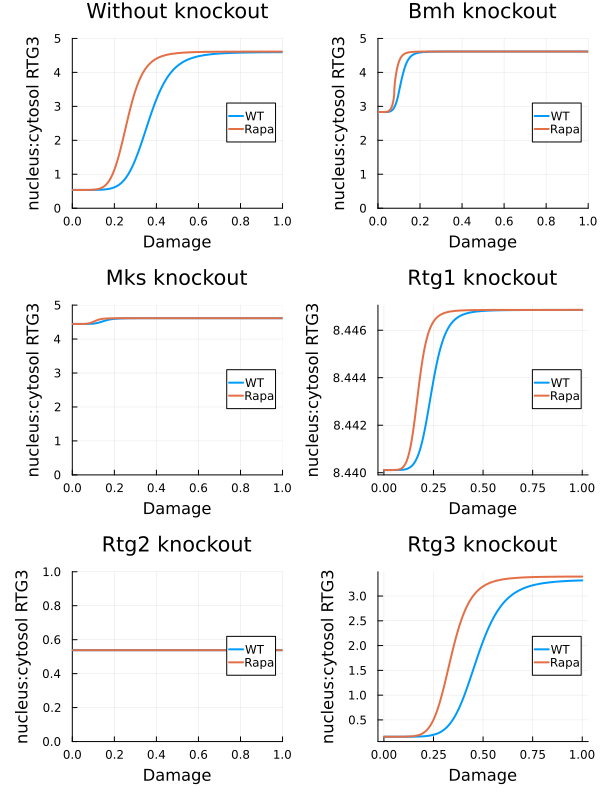

In [10]:
pl1 = plot(
    [f_r3nc_wt f_r3nc_ra], 0.0, 1.0,
    label=["WT" "Rapa"], lw=2, legend=:right,
    xlims=(0.0, 1.0), ylims=(0.0, 5.0),
    xlabel="Damage", ylabel="nucleus:cytosol RTG3",
    title = "Without knockout")

pl2 = plot(
    [f_r3nc_ΔBmh f_r3nc_ΔBmh_ra], 0.0, 1.0,
    label=["WT" "Rapa"], lw=2, legend=:right,
    xlims=(0.0, 1.0), ylims=(0.0, 5.0),
    xlabel="Damage", ylabel="nucleus:cytosol RTG3",
    title = "Bmh knockout")

pl3 = plot(
    [f_r3nc_ΔMks f_r3nc_ΔMks_ra], 0.0, 1.0,
    label=["WT" "Rapa"], lw=2, legend=:right,
    xlims=(0.0, 1.0), ylims=(0.0, 5.0),
    xlabel="Damage", ylabel="nucleus:cytosol RTG3",
    title = "Mks knockout")

pl4 = plot(
    [f_r3nc_ΔRtg1 f_r3nc_ΔRtg1_ra], 0.0, 1.0,
    label=["WT" "Rapa"], lw=2, legend=:right,
    # xlims=(0.0, 1.0), ylims=(0.0, 5.0),
    xlabel="Damage", ylabel="nucleus:cytosol RTG3",
    title = "Rtg1 knockout")

pl5 = plot(
    [f_r3nc_ΔRtg2 f_r3nc_ΔRtg2_ra], 0.0, 1.0,
    label=["WT" "Rapa"], lw=2, legend=:right,
    xlims=(0.0, 1.0), ylims=(0.0, 1.0),
    xlabel="Damage", ylabel="nucleus:cytosol RTG3",
    title = "Rtg2 knockout")

pl6 = plot(
    [f_r3nc_ΔRtg3 f_r3nc_ΔRtg3_ra], 0.0, 1.0,
    label=["WT" "Rapa"], lw=2, legend=:right,
    # xlims=(0.0, 1.0), ylims=(0.0, 5.0),
    xlabel="Damage", ylabel="nucleus:cytosol RTG3",
    title = "Rtg3 knockout")

plot(pl1, pl2, pl3, pl4, pl5, pl6, layout = (3, 2), size=(600, 800), left_margin = 5mm)


## Gene knockout and Rtg 3 distribution

In [11]:
colors = [:black :red :orange :purple :green :blue]
labels = ["WT" "ΔBmh" "ΔMks" "ΔRtg1" "ΔRtg2" "ΔRtg3"]
labels_rapa = labels .* " (Rapa)"


1×6 Matrix{String}:
 "WT (Rapa)"  "ΔBmh (Rapa)"  "ΔMks (Rapa)"  …  "ΔRtg2 (Rapa)"  "ΔRtg3 (Rapa)"

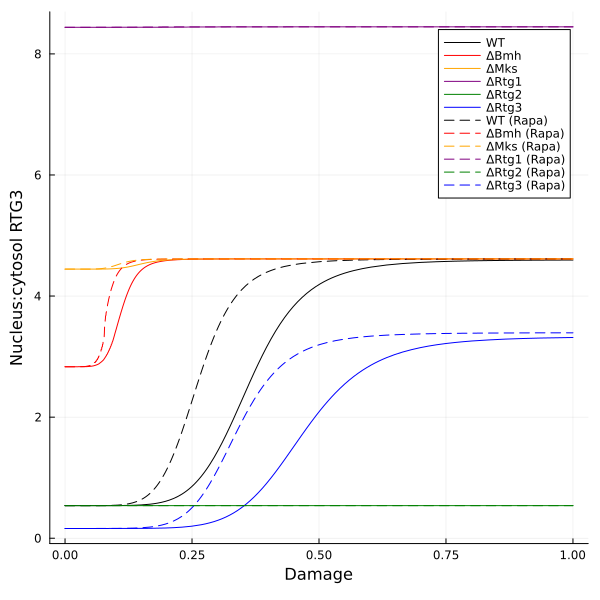

In [12]:
plot([f_r3nc_wt f_r3nc_ΔBmh f_r3nc_ΔMks f_r3nc_ΔRtg1 f_r3nc_ΔRtg2 f_r3nc_ΔRtg3], 0.0, 1.0,
label=labels, linestyle=:solid, linecolor=colors,
xlabel="Damage", ylabel="Nucleus:cytosol RTG3")

plot!([f_r3nc_ra f_r3nc_ΔBmh_ra f_r3nc_ΔMks_ra f_r3nc_ΔRtg1_ra f_r3nc_ΔRtg2_ra f_r3nc_ΔRtg3_ra], 0.0, 1.0,
label = labels_rapa, linestyle=:dash, linecolor = colors,
xlabel="Damage", ylabel="Nucleus:cytosol RTG3", size=(600, 600))


## RTG2 mutation and Mks1 binding

We assume RTG2 mutation stablize the Rtg2-Mks complex.

In [13]:
signals = range(0.0, 1.0, 101)
idxkn2M = psmap[rs.kn2M]

sols = map(signals) do s
    p = copy(prob.p)
    p[idxmulS] = s
    solve(remake(prob, p=p), DynamicSS(Rodas5()))
end

sols_mRtg2 = map(signals) do s
    p = copy(prob.p)
    p[idxmulS] = s
    p[idxkn2M] *= 1e-4
    sol = solve(remake(prob, p=p), DynamicSS(Rodas5()))
end

extract(sols, k) = map(sols) do s; s[k] end

mkssol = map(sols) do s; s[rs.Mks] end
bmhmks = map(sols) do s; s[rs.BmhMks] end
mksrtg2sol = map(sols) do s; s[rs.Rtg2Mks_c] end
mksmRtg2 = map(sols_mRtg2) do s; s[rs.Mks] end
bmhmksmRtg2 = map(sols_mRtg2) do s; s[rs.BmhMks] end
mksrtg2mRtg2 = map(sols_mRtg2) do s; s[rs.Rtg2Mks_c] end


101-element Vector{Float64}:
  1.5095743912939076e-14
  3.732209650043909e-9
  4.777231852046594e-7
  0.15648219368561395
  1.1401181402960754
  3.393757598470514
 10.826224155938347
 46.59991750299502
 47.34440400195727
 47.60325201913246
 47.70882363837045
 47.75603020397504
 47.77876687779426
  ⋮
 47.805899936132526
 47.80589993778726
 47.80589993930124
 47.80589994068779
 47.805899941958856
 47.80589994312515
 47.80589994419627
 47.80589994518088
 47.80589994608676
 47.805899946920924
 47.80589994768969
 47.80589994839877

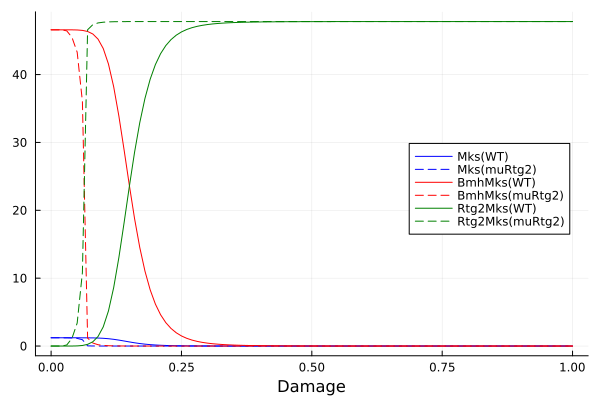

In [14]:
lss = [:solid :dash]
labels=["(WT)" "(muRtg2)"]

plot(signals, [mkssol mksmRtg2], linestyle=lss, linecolor=:blue, labels="Mks" .* labels)
plot!(signals, [bmhmks bmhmksmRtg2], linestyle=lss, linecolor=:red, labels="BmhMks" .* labels)
plot!(signals, [mksrtg2sol mksrtg2mRtg2], linestyle=lss, linecolor=:green, labels="Rtg2Mks" .* labels)
plot!(xlabel="Damage", legend=:right)
